<a href="https://colab.research.google.com/github/Mu-niu13/X-Ray-Transparency-Lab/blob/main/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# X-Ray Transparency Lab – GPU Training

This Colab notebook trains the pneumonia classifier on GPU and generates embeddings. We then download the trained model + embeddings and use them locally.

**Steps:**

1. Enable GPU: **Runtime → Change runtime type → GPU (T4)**
2. Run all cells in order
3. Download the generated `trained_model.zip` at the end
4. Extract it into your local repo (it will create `models/` and `embeddings/`)

## 1. Setup Environment

In [2]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


## 2. Kaggle Credentials & Download Data

In [3]:
# Upload your kaggle.json file
from google.colab import files
import os

print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json


In [4]:
# Download dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d data
!rm chest-xray-pneumonia.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:23<00:00, 267MB/s]
100% 2.29G/2.29G [00:23<00:00, 106MB/s]


In [5]:
# Verify dataset structure
!ls -R data/chest_xray/ | head -20

data/chest_xray/:
chest_xray
__MACOSX
test
train
val

data/chest_xray/chest_xray:
test
train
val

data/chest_xray/chest_xray/test:
NORMAL
PNEUMONIA

data/chest_xray/chest_xray/test/NORMAL:
IM-0001-0001.jpeg
IM-0003-0001.jpeg
IM-0005-0001.jpeg


## 3. Training

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import numpy as np
from pathlib import Path
import os

class ChestXRayDataset(Dataset):
    """Dataset for chest X-ray images"""
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.images = []
        self.labels = []

        # NORMAL images (label 0)
        normal_dir = self.data_dir / 'NORMAL'
        if normal_dir.exists():
            for img_path in normal_dir.glob('*.jpeg'):
                self.images.append(str(img_path))
                self.labels.append(0)

        # PNEUMONIA images (label 1)
        pneumonia_dir = self.data_dir / 'PNEUMONIA'
        if pneumonia_dir.exists():
            for img_path in pneumonia_dir.glob('*.jpeg'):
                self.images.append(str(img_path))
                self.labels.append(1)

        print(f"Loaded {len(self.images)} images: "
              f"{self.labels.count(0)} normal, {self.labels.count(1)} pneumonia")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


def create_model(pretrained=True):
    """Create ResNet18 model for binary classification"""
    model = models.resnet18(pretrained=pretrained)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)
    return model


def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100 * correct / total
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100 * correct / total
    return val_loss, val_acc

## 4. Train Model

Using device: cuda
Loading training data...
Loaded 5216 images: 1341 normal, 3875 pneumonia
Train samples: 4694
Val samples: 522
Creating model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


Ready to train!

Epoch 1/10


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]



Train Loss: 0.0936, Train Acc: 95.80%
Val Loss: 0.1571, Val Acc: 94.06%
Saved best model with val_acc: 94.06%

Epoch 2/10


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]



Train Loss: 0.0435, Train Acc: 98.30%
Val Loss: 0.0710, Val Acc: 97.32%
Saved best model with val_acc: 97.32%

Epoch 3/10


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]



Train Loss: 0.0312, Train Acc: 98.85%
Val Loss: 0.0814, Val Acc: 97.13%

Epoch 4/10


Validating: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]



Train Loss: 0.0338, Train Acc: 98.87%
Val Loss: 0.0745, Val Acc: 97.32%

Epoch 5/10


Validating: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]



Train Loss: 0.0311, Train Acc: 98.70%
Val Loss: 0.0452, Val Acc: 98.08%
Saved best model with val_acc: 98.08%

Epoch 6/10


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]



Train Loss: 0.0096, Train Acc: 99.68%
Val Loss: 0.0768, Val Acc: 97.89%

Epoch 7/10


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]



Train Loss: 0.0121, Train Acc: 99.60%
Val Loss: 0.0592, Val Acc: 97.70%

Epoch 8/10


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]



Train Loss: 0.0063, Train Acc: 99.74%
Val Loss: 0.0613, Val Acc: 98.08%

Epoch 9/10


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]



Train Loss: 0.0034, Train Acc: 99.94%
Val Loss: 0.0425, Val Acc: 98.47%
Saved best model with val_acc: 98.47%

Epoch 10/10


Validating: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]



Train Loss: 0.0010, Train Acc: 99.98%
Val Loss: 0.0375, Val Acc: 99.23%
Saved best model with val_acc: 99.23%

Training complete! Best validation accuracy: 99.23%


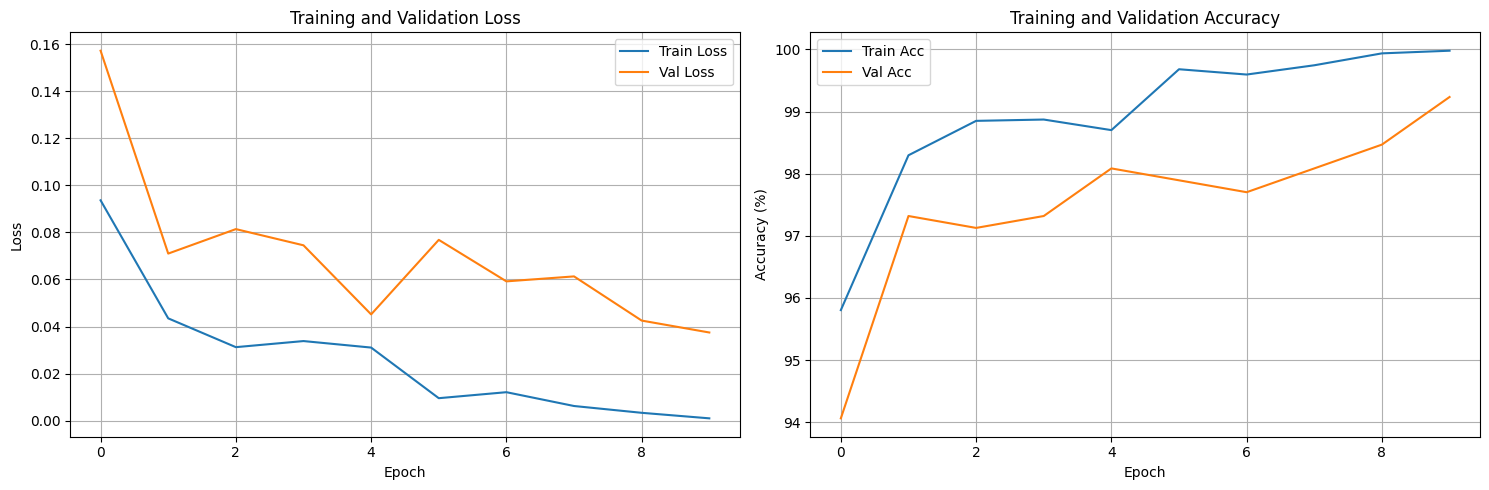

In [8]:
# Configuration
EPOCHS = 10
BATCH_SIZE = 64  # larger batch size for GPU
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets
print("Loading training data...")
train_dataset = ChestXRayDataset('data/chest_xray/train', transform=train_transform)

# Train/val split
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Use val transform on val dataset
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# Create model, loss, optimizer, scheduler
print("Creating model...")
model = create_model(pretrained=True).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

print("Ready to train!")

# Training loop
best_val_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print('='*60)

    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        os.makedirs('models', exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'models/pneumonia_classifier.pth')
        print(f"Saved best model with val_acc: {val_acc:.2f}%")

print(f"\n{'='*60}")
print(f"Training complete! Best validation accuracy: {best_val_acc:.2f}%")
print('='*60)

# Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Generate Embeddings

In [9]:
import faiss
import pickle

class FeatureExtractor(nn.Module):
    """Extract features from penultimate layer"""
    def __init__(self, model):
        super().__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

# Load best model
model = create_model(pretrained=False)
checkpoint = torch.load('models/pneumonia_classifier.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

feature_extractor = FeatureExtractor(model).to(device)
feature_extractor.eval()

print("Feature extractor ready!")

# Generate embeddings for training set
print("Generating embeddings...")

full_train_dataset = ChestXRayDataset(
    'data/chest_xray/train', transform=val_transform
)
train_loader_embed = DataLoader(
    full_train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

all_embeddings = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(train_loader_embed, desc="Generating embeddings"):
        images = images.to(device)
        embeddings = feature_extractor(images)
        all_embeddings.append(embeddings.cpu().numpy())
        all_labels.extend(labels.numpy())

all_paths = full_train_dataset.images
all_embeddings = np.vstack(all_embeddings)
all_labels = np.array(all_labels)

print(f"Generated {len(all_embeddings)} embeddings of dimension {all_embeddings.shape[1]}")

# Save embeddings and create FAISS index
os.makedirs('embeddings', exist_ok=True)

np.save('embeddings/embeddings.npy', all_embeddings)
np.save('embeddings/labels.npy', all_labels)

with open('embeddings/paths.pkl', 'wb') as f:
    pickle.dump(all_paths, f)

dimension = all_embeddings.shape[1]
faiss.normalize_L2(all_embeddings)
index = faiss.IndexFlatIP(dimension)
index.add(all_embeddings.astype('float32'))
faiss.write_index(index, 'embeddings/similarity_index.faiss')

print("Embeddings saved!")
print(f"  - embeddings.npy: {all_embeddings.shape}")
print(f"  - labels.npy: {all_labels.shape}")
print(f"  - paths.pkl: {len(all_paths)} paths")
print("  - similarity_index.faiss")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Feature extractor ready!
Generating embeddings...
Loaded 5216 images: 1341 normal, 3875 pneumonia


Generating embeddings: 100%|██████████| 82/82 [01:12<00:00,  1.13it/s]

Generated 5216 embeddings of dimension 512
Embeddings saved!
  - embeddings.npy: (5216, 512)
  - labels.npy: (5216,)
  - paths.pkl: 5216 paths
  - similarity_index.faiss


## 6. Download Trained Files

In [10]:
# Zip model + embeddings + training plot
!zip -r trained_model.zip models/ embeddings/ training_history.png

print("Created trained_model.zip")
print("\nContents:")
!unzip -l trained_model.zip

# Download the zip file to your local machine
from google.colab import files

print("Downloading trained_model.zip...")
files.download('trained_model.zip')

  adding: models/ (stored 0%)
  adding: models/pneumonia_classifier.pth (deflated 8%)
  adding: embeddings/ (stored 0%)
  adding: embeddings/similarity_index.faiss (deflated 16%)
  adding: embeddings/labels.npy (deflated 100%)
  adding: embeddings/paths.pkl (deflated 91%)
  adding: embeddings/embeddings.npy (deflated 16%)
  adding: training_history.png (deflated 9%)
Created trained_model.zip

Contents:
Archive:  trained_model.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
        0  2025-11-23 01:08   models/
134266505  2025-11-23 01:19   models/pneumonia_classifier.pth
        0  2025-11-23 01:21   embeddings/
 10682413  2025-11-23 01:21   embeddings/similarity_index.faiss
    41856  2025-11-23 01:21   embeddings/labels.npy
   312825  2025-11-23 01:21   embeddings/paths.pkl
 10682496  2025-11-23 01:21   embeddings/embeddings.npy
   105403  2025-11-23 01:19   training_history.png
---------                     -------
156091498                     8 files


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>